In [4]:
import json
import time

from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import distance
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from GravitationalFieldProblem.dataset import GravitationalDataset
from GravitationalFieldProblem.models import NewPlanetsModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Train on device : {device}")

Train on device : cuda


In [5]:
d = 2
dataset = GravitationalDataset(2,1000,[torch.tensor([0.5,0.5],device = "cpu")],10,0,noise_level=0)
model = NewPlanetsModel(2)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
model.load_weights(f"ridge_field_big.pth", device = "cuda")
model.to(device)

linspaces = [torch.linspace(0, 1, 300) for _ in range(2)]
grids = torch.meshgrid(*linspaces, indexing='ij')  # 'ij' indexing for Cartesian coordinates
hypergrid = torch.stack(grids, dim=-1).reshape(-1, 2)

model = model.cpu()
model.eval()
hypergrid = hypergrid.detach()
c = model(hypergrid).data.squeeze(1).numpy()

plt.scatter(hypergrid[:,0], hypergrid[:,1], c=c,  # Color by potential values
    cmap='viridis', s=20)
plt.axis("equal")

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    hypergrid[:,0], hypergrid[:,1],
    c,
    c=c,
    cmap='viridis', 
    s=0.5
)
plt.axis("off")
plt.colorbar(scatter, ax=ax, label="Potential")
plt.show()

true_potential = dataset._planet_potential(hypergrid, torch.tensor([[0.5,0.5]],device = "cpu"),0.1).detach()
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    hypergrid[:,0], hypergrid[:,1],
    true_potential,
    c=true_potential,
    cmap='viridis', 
    s=0.5
)
plt.axis("off")
plt.colorbar(scatter, ax=ax, label="Potential")
plt.show()

Total number of parameters: 12737


FileNotFoundError: [Errno 2] No such file or directory: 'ridge_field_big.pth'

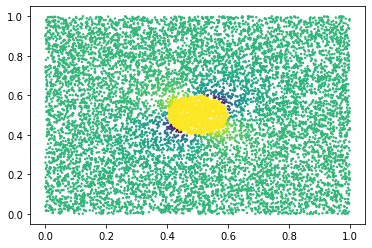

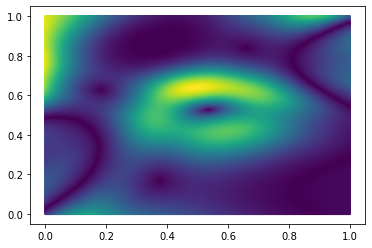

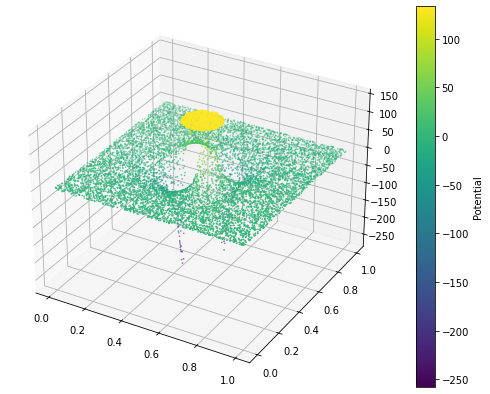

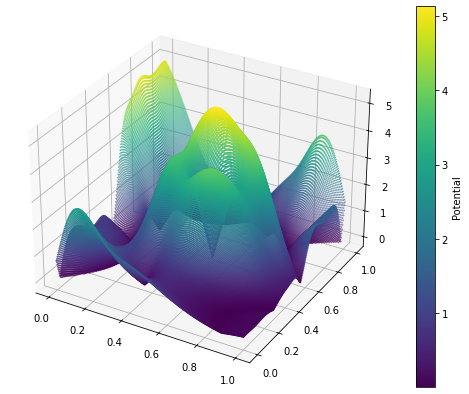

In [ ]:
# print(4 / (3 * R**2))
# distances = torch.norm(planets_tensor.unsqueeze(1).cpu() - dataset.points.unsqueeze(0).cpu(), dim=-1)

# inside_planet = distances < 0.1

# inside_planet = inside_planet.any(dim=0)
# print(inside_planet.shape)
# plt.scatter(dataset.points.detach()[:,0], dataset.points.detach()[:,1], c=inside_planet.squeeze(0).detach(),  # Color by potential values
#     cmap='viridis', s=20)

# plt.show()

true_lap = dataset.laplacian.to("cuda")
true_grad = dataset.gradients
# true_resid = true_lap.unsqueeze(0)
# true_resid = torch.where(inside_planet, true_resid - 4 / (3 * R**2), true_resid)

model.eval()
model = model.to("cuda")
model_residuals = model.compute_residual(hypergrid,0.1,true_lap,
                                         torch.tensor([[0.5,0.5]],device = "cpu").to("cuda"))[2]
# model_residuals = torch.clip(model_residuals,-140, 140)

# error_lap = (true_lap - model_residuals).abs()
# error_lap[error_lap.abs()<1] = 0
# error_lap[error_lap.abs()>1] = 1
# print(model_residuals)
hypergrid = hypergrid.detach().numpy()
plt.scatter(dataset.points.detach()[:,0],
            dataset.points.detach()[:,1],
            c=true_lap.squeeze(0).detach().cpu(),  # Color by potential values
    cmap='viridis', s=2)

plt.show()

plt.scatter(hypergrid[:,0],
            hypergrid[:,1],
            c=model_residuals.squeeze(0).detach().cpu(),  # Color by potential values
    cmap='viridis', s=2)

plt.show()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    dataset.points.detach()[:,0],
    dataset.points.detach()[:,1],
    true_lap.squeeze(0).detach().cpu(),
    c=true_lap.squeeze(0).detach().cpu(),
    cmap='viridis', 
    s=0.5
)

plt.colorbar(scatter, ax=ax, label="Potential")
plt.show()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    hypergrid[:,0],
    hypergrid[:,1],
    model_residuals.detach().cpu(),
    c=model_residuals.detach().cpu() ,
    cmap='viridis', 
    s=0.5
)

plt.colorbar(scatter, ax=ax, label="Potential")
plt.show()

In [ ]:
true_grad.max()

tensor(6.6623, grad_fn=<MaxBackward1>)